# Kernel PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# define kernel
class Kernel:
    def __init__(self):
        return
    
    # set Kernel    
    def setKernel(self, name, para = None ):
        self.name = name # type of kernel
        self.para = para # hyper parameter
    
    
    def __str__(self):
        return "Current kernel: "+self.name+', hyper parameter:'+str(self.para)
    
    # compute the Kernel matrix
    def dot(self, X1, X2):
        X1X2 = X1.dot(X2.T)
        if self.name == 'Gaussian':
            XX1 = np.matlib.repmat( np.diag( X1.dot(X1.T) ), X2.shape[0], 1 ).T
            XX2 = np.matlib.repmat( np.diag( X2.dot(X2.T) ), X1.shape[0], 1 )
            
            return np.exp(- ( XX1+XX2-2*X1X2 )/(self.para**2) )
        elif self.name == 'Vovk':
            return (1 - (X1X2**self.para) )/( 1 - X1X2 )
        
        # apply no transform on the data
        elif self.name == 'Euclidean': 
            return X1X2
        else:
            raise ValueError





# define my own Kernel PCA
class MyKPCA:
    def __init__(self, kernel = None):
        self.alpha = [] # principal components (score), the alpha vectors
        self.kernel = kernel
        
    def setKernel(self, kernel):
        self.kernel = kernel
        print( kernel )
    
    # find the first k principla directions in the RKHS, the alpha vectors
    def fit(self, X, k, n_iter):
        self.Data = X
        n = X.shape[0]
        K = self.kernel.dot( X, X ) # kernel matrix
        P = np.eye(n) - (1/n)*np.ones([n,n])
        K = P.dot(K).dot(P) # centered K

        for i in range(k):
            e_value, e_vector = self.PowerIter( K, n_iter )

            if abs(e_value) < 1e-10:
                break
            else:

                self.alpha.append( e_vector/np.sqrt( e_value ) )
                K = K - e_value*e_vector.dot( e_vector.T )

    
    # use the power method to find the fisrt eigenvector of a symmetric matrix XX  
    def PowerIter(self, XX, n_iter):
        n = XX.shape[0]
        
        # initialization
        e_vector = np.ones( n )/np.sqrt(n) 
        e_value = 0
        for i in range(n_iter):
            e_vector = XX.dot( e_vector )
            e_vector = e_vector/ np.sqrt( ( e_vector**2 ).sum() )
        
        e_value = e_vector.dot( XX ).dot(e_vector)
        return e_value, e_vector[:, np.newaxis ]
    
    
    # find the kernel PCs of X  
    def predict( self, X ):
        k = len( self.alpha )
        m = X.shape[0]
        PC = np.empty( [m,k] )
        
        K = self.kernel.dot( X, self.Data )
        # center K
        K =   K - np.matlib.repmat( K.mean(1), m,1 )
        
        for i in range( k ):
            PC[:,i] = K.dot( self.alpha[i] ).flatten()
        
        return PC

## Generate Data

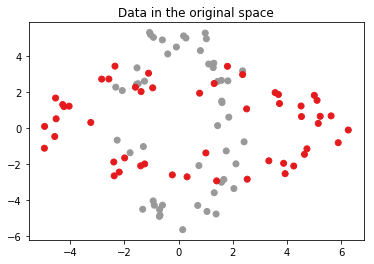

In [3]:
np.random.seed(1)
n_sample = 50

angle1 = np.random.uniform( 0, 2*np.pi, n_sample )
#m1 = np.array([0,0])
#cov1 = np.array( [[1, 0.5],[0.5,1]] )

X1 = np.vstack( [ 2*np.cos(angle1), 5*np.sin(angle1) ]  ).T + np.random.normal( 0,0.5, [n_sample, 2] )

#X1 = np.random.multivariate_normal( m1, cov1, n_sample )


#m2 = np.array( [-3,-3] )
#cov2 = np.array( [[1, -0.5],[-0.5,2]] )
#X2 = np.random.multivariate_normal( m2, cov2, n_sample )


angle2 = np.random.uniform( 0, 2*np.pi, n_sample )
X2 = np.vstack( [ 5*np.cos(angle1), 2.5*np.sin(angle1) ]  ).T + np.random.normal( 0,0.5, [n_sample, 2] )



X = np.vstack( [X1, X2] )
y = np.repeat( [1,-1], n_sample )

plt.scatter( X[:,0], X[:,1], c = y, cmap = 'Set1' )
plt.title('Data in the original space')
plt.show()

### Test Case: Normal PCA
As a test case, we can use my own KPCA to implement PCA to see if the result is consistent with that of PCA of sklearn. And as we can seen from the plots below, the result are identical. It verifies the correstness of my implementation of KPCA.

Current kernel: Euclidean, hyper parameter:None


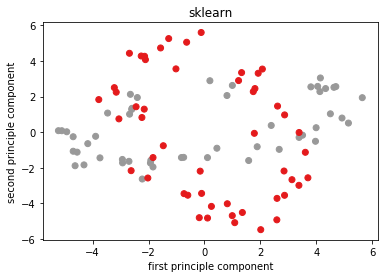

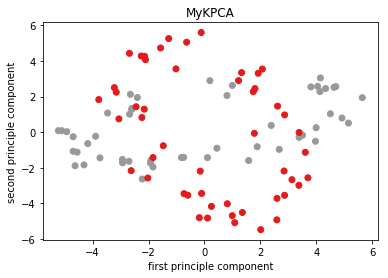

In [5]:
# test case: normal PCA
k = Kernel( )
mypca = MyKPCA()

# MyKPCA with Euclidean kernel leads to normal PCA
k.setKernel( 'Euclidean' )
mypca.setKernel( k )
mypca.fit(X, 2, 1000)
PCs = mypca.predict( X )

# PCA of sklearn
plt.figure()
pca = PCA(2)
X_low = pca.fit_transform(X)

plt.scatter(X_low[:,0], X_low[:,1], c = y, cmap = 'Set1')
plt.xlabel('first principle component')
plt.ylabel('second principle component')
plt.title('sklearn')
plt.show()


# MyKPCA
plt.figure()
plt.scatter( PCs[:,0], -PCs[:,1], c = y, cmap = 'Set1')
plt.xlabel('first principle component')
plt.ylabel('second principle component')
plt.title('MyKPCA')
plt.show()


### Vovk Kernel
When the hyperparameter equals to 2, the data on the first two kernel principals looks similar as in the original space. But for other parameters, the patterns in RKHS are quite different with that in the original space. For example, when the hyperparameter is 6, the two groups lie on different lines in the first two principal components.

Current kernel: Vovk, hyper parameter:2


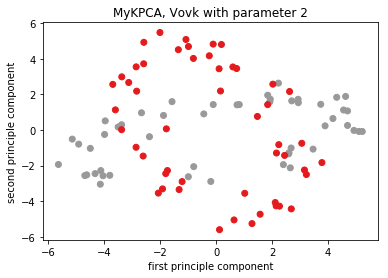

Current kernel: Vovk, hyper parameter:3


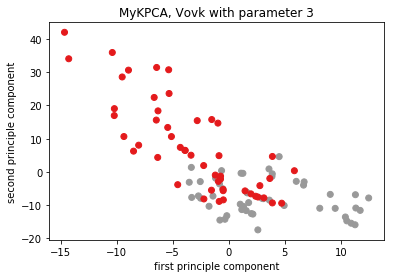

Current kernel: Vovk, hyper parameter:4


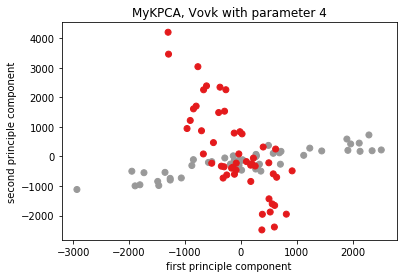

Current kernel: Vovk, hyper parameter:5


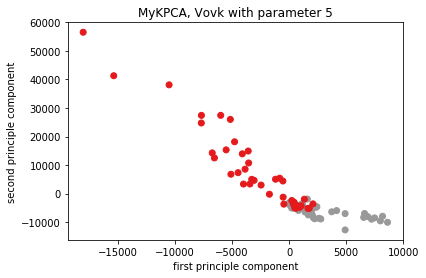

Current kernel: Vovk, hyper parameter:6


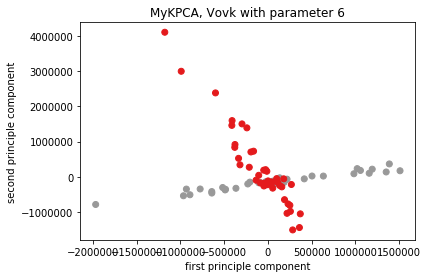

Current kernel: Vovk, hyper parameter:10


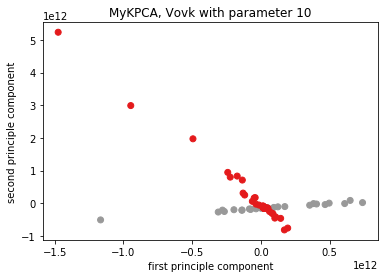

Current kernel: Vovk, hyper parameter:15


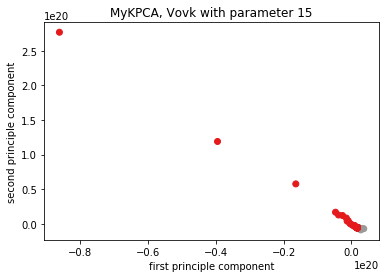

In [6]:
Para = [2,3,4,5,6, 10, 15]
for sigma in Para:
    k.setKernel( 'Vovk', sigma )
    mypca.setKernel( k )
    mypca.fit(X, 2, 1000)
    PCs = mypca.predict( X )
    
    plt.figure()
    plt.scatter( -PCs[:,0], PCs[:,1], c = y, cmap = 'Set1')
    plt.xlabel('first principle component')
    plt.ylabel('second principle component')
    plt.title('MyKPCA, '+k.name+' with parameter '+ str(k.para)   )
    plt.show()